In [130]:
import matplotlib.pyplot as plt
import polars as pl
from glob import glob
%matplotlib

## Capacity distribution

Upper row: linear buckets, lower row: log2 buckets\
Left column: node count, right column: sum capacity

Skew = 1: every linear bucket has similar capacity, every log2 bucket has similar node

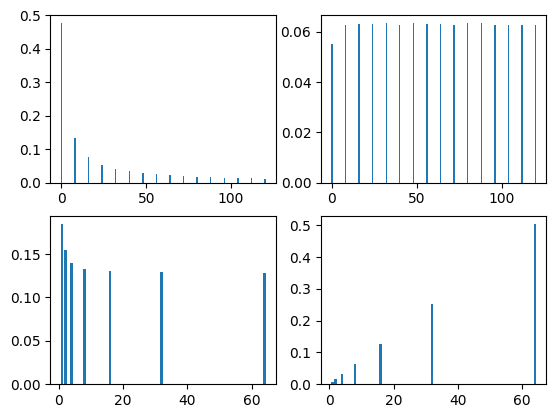

In [39]:
df = pl.read_csv("capacity_distr.csv").filter(pl.col("method") == "Offset")


def plot(skew):
    fig, axs = plt.subplots(2, 2)
    for row, ty in [(0, "Linear"), (1, "Log2")]:
        skew1_df = df.filter(
            pl.col("skew") == skew, pl.col("bucket_type") == ty
        ).with_columns(
            pl.col("node_count") / pl.col("node_count").sum(),
            pl.col("sum_capacity") / pl.col("sum_capacity").sum(),
        )
        data = skew1_df.select(
            "class_start_capacity", "node_count", "sum_capacity"
        ).to_numpy()
        axs[row, 0].bar(data[:, 0], data[:, 1])
        axs[row, 1].bar(data[:, 0], data[:, 2])


plot(1.0)

Skew = 2 (1.9 is better): every log bucket has similar capacity

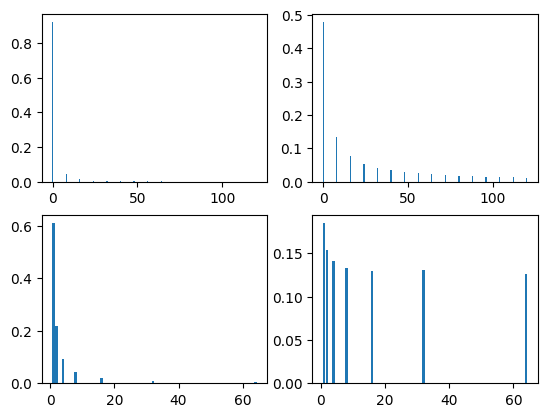

In [40]:
plot(2.0)

## Workload distribution

In [148]:
workloads = []
for workload_dir in glob("workload/*"):
    spec = pl.read_csv(f"{workload_dir}/spec.csv").to_dicts()[0]
    print(workload_dir, spec)
    snapshot_df = pl.read_csv(f"{workload_dir}/*/snapshot.csv")
    agg_df = (
        snapshot_df.group_by("at")
        .agg(
            pl.col("num_data").mean(),
            pl.col("max_num_data").max(),
        )
        .sort("at")
    )
    workloads.append({"spec": spec, "snapshot": snapshot_df, "snapshot_agg": agg_df})

workload/1742276506 {'num_node': 10000, 'ingest_rate': 0.1, 'expire_duration': 10000000, 'num_copy': 10}
workload/1742275585 {'num_node': 10000, 'ingest_rate': 0.1, 'expire_duration': 10000000, 'num_copy': 3}
workload/1742276450 {'num_node': 10000, 'ingest_rate': 0.1, 'expire_duration': 10000000, 'num_copy': 5}


In [149]:
def workload(num_copy, num_node):
    return next(
        workload
        for workload in workloads
        if workload["spec"]["num_copy"] == num_copy
        and workload["spec"]["num_node"] == num_node
    )

### Current workload at first snapshot

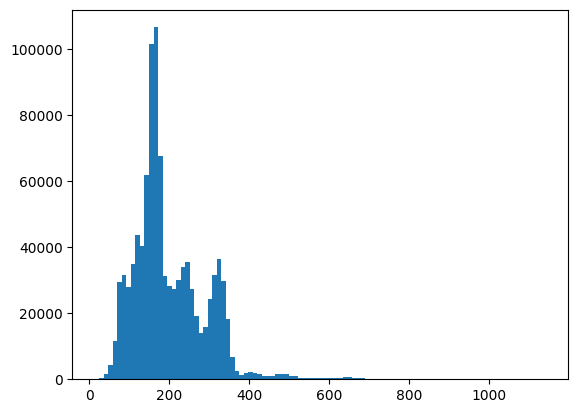

In [151]:
def plot(df):
    agg_df = df.filter(pl.col("at") == 10_000_000)
    fig, ax = plt.subplots()
    ax.hist(agg_df["num_data"], bins=100)


plot(workload(3, 10_000)["snapshot"])

### ECDF of current workload of every snapshot

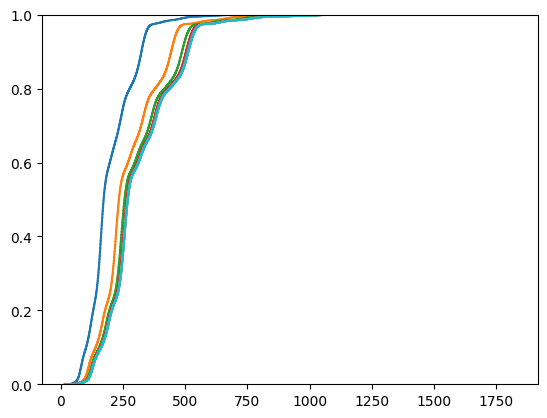

In [152]:
def plot(df):
    fig, ax = plt.subplots()
    for at in [(k + 1) * 10_000_000 for k in range(10)]:
        ax.ecdf(df.filter(pl.col("at") == at)["num_data"])


plot(workload(3, 10_000)["snapshot"])

### Mean/max workload of every snapshot

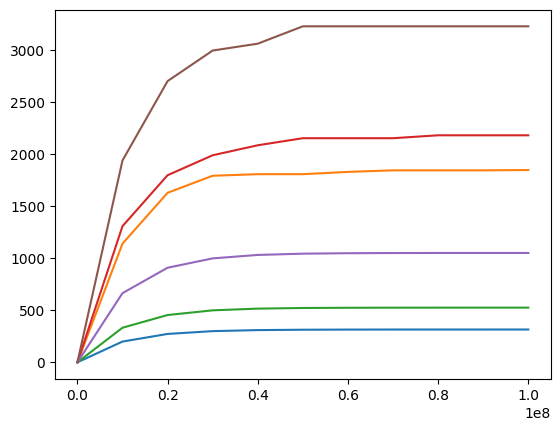

In [153]:
fig, ax = plt.subplots()


def plot(df):
    ax.plot(df["at"], df["num_data"])
    ax.plot(df["at"], df["max_num_data"])


plot(workload(3, 10_000)["snapshot_agg"])
plot(workload(5, 10_000)["snapshot_agg"])
plot(workload(10, 10_000)["snapshot_agg"])

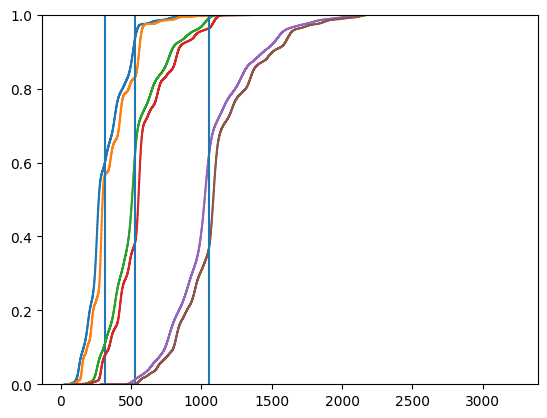

In [155]:
fig, ax = plt.subplots()


def plot(workload):
    plot_df = workload["snapshot"].filter(pl.col("at") == 100_000_000)
    ax.ecdf(plot_df["num_data"])
    ax.ecdf(plot_df["max_num_data"])
    ax.vlines(
        workload["snapshot_agg"].filter(pl.col("at") == 100_000_000)["num_data"], 0, 1
    )


plot(workload(3, 10_000))
plot(workload(5, 10_000))
plot(workload(10, 10_000))